In [2]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN
import pysindy as ps
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN, NullWork
from architectures import FNN, StackedNN
from utils import compute_grad
from NavierStokesData import NavierStokesData

In [3]:
class NavierStokesUPINN(UPINN):
    
    def F_input(self, Z, U):
        
        psi = U[:, 0:1]
        
        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        return torch.cat([Z, u, v], dim=1)


In [4]:
hidden = [64] * 8

u = FNN(
    dims=[3, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[5, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [5]:
# u1 = FNN(
#     dims=[3, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# u2 = FNN(
#     dims=[3, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# u = StackedNN([u1, u2])

# F1 = FNN(
#     dims=[5, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# F2 = FNN(
#     dims=[5, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# F = StackedNN([F1, F2])

In [6]:
model = NavierStokesUPINN(u, N=NullWork(), F=F)

[Info]: Initializing UPINN model


In [7]:
name = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-2000-noise001_new'
model.load(name, 'models')

### Sample data from UPINN

In [8]:
x = torch.linspace(2, 8, 50)
y = torch.linspace(-2, 2, 50)
t = torch.linspace(0, 20, 50)
domain_shape = (len(x), len(y), len(t))

X, Y, T = torch.meshgrid(x, y, t)

Z = torch.stack([X, Y, T], dim=3).reshape(-1, 3)
Z.requires_grad_(True)

U_pred = model.u(Z)
F_pred = model.F(model.F_input(Z, U_pred))

Psi = U_pred[:, 0:1]
Psi_Z = compute_grad(Psi, Z)
Psi_X = Psi_Z[:, 0:1]
Psi_Y = Psi_Z[:, 1:2]

U_pred = Psi_Y.detach().numpy().reshape(*domain_shape)
V_pred = -Psi_X.detach().numpy().reshape(*domain_shape)

u = np.stack([U_pred, V_pred], axis=3)

u_dot = F_pred.reshape(*domain_shape, 2).detach().numpy()

### Define function library

In [9]:
X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
t = t.detach().numpy()

library_functions = [
    lambda x: x,
    # lambda x: x * x * x,
    # lambda x, y: x * y * y,
    # lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    # lambda x: x + x + x,
    # lambda x, y: x + y + y,
    # lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    # include_bias=True,
    is_uniform=True,
    include_interaction=True,
    # periodic=True
)

In [303]:
from sklearn.metrics import explained_variance_score, mean_squared_error

In [304]:
# train_idx = np.arange(0, 0.8*len(t), dtype=int)
# test_idx = np.arange(0.8*len(t), len(t), dtype=int)


# scores = []
# taus = np.linspace(0.1, 2, 20)

# for tau in taus:
#     optimizer = ps.SR3(
#         threshold=tau,
#         max_iter=1000,
#         thresholder="l1",
#         normalize_columns=True,
#     )
#     model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v'])
#     model_sindy.fit(x=u[:,:,train_idx,:], t=t[train_idx], x_dot=u_dot[:,:,train_idx,:])
#     if model_sindy.complexity == 0:
#         break
#     scores.append(model_sindy.score(x=u[:,:,test_idx,:], t=t[test_idx]))
#     print(f'Threshold: {tau}, Score: {scores[-1]}')

In [11]:
cv_folds = TimeSeriesSplit(n_splits=5)
scores = []
min_score = []
max_score = []
taus = np.linspace(0.1, 2, 20)
for t_ in taus:
    optimizer = ps.SR3(
        threshold=t_,
        max_iter=100000,
        thresholder="l1",
        normalize_columns=True,
    )
    model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v'])
    cv_scores = []
    for train_idx, test_idx in tqdm(cv_folds.split(t)):
        model_sindy.fit(x=u[:, :, train_idx, :], t=t[train_idx], x_dot=u_dot[:, :, train_idx, :])
        cv_scores.append(model_sindy.score(x=u[:, :, test_idx, :], t=t[test_idx]))
    scores.append(np.mean(cv_scores))
    min_score.append(np.min(cv_scores))
    max_score.append(np.max(cv_scores))
    print(f'Threshold: {t_},\n Mean Score: {scores[-1]}')
    # print(f'Min Score: {min_score[-1]}')
    # print(f'Max Score: {max_score[-1]}')

best_tau = taus[np.argmin(scores)]

5it [00:34,  6.90s/it]


Threshold: 0.1,
 Mean Score: -0.009764576160193305


5it [00:18,  3.78s/it]


Threshold: 0.2,
 Mean Score: -0.008607790960123828


5it [00:12,  2.47s/it]


Threshold: 0.3,
 Mean Score: -0.007496803380121308


5it [00:08,  1.77s/it]


Threshold: 0.4,
 Mean Score: -0.006369487220263692


5it [00:08,  1.70s/it]


Threshold: 0.5,
 Mean Score: -0.006345940311919729


5it [00:06,  1.36s/it]


Threshold: 0.6,
 Mean Score: -0.006417618321764041


5it [00:06,  1.23s/it]


Threshold: 0.7,
 Mean Score: -0.005961820481448976


5it [00:05,  1.07s/it]


Threshold: 0.7999999999999999,
 Mean Score: -0.005915983713976303


5it [00:04,  1.01it/s]


Threshold: 0.8999999999999999,
 Mean Score: -0.005389187264306328


5it [00:04,  1.07it/s]


Threshold: 0.9999999999999999,
 Mean Score: -0.005389187264306328


5it [00:04,  1.10it/s]


Threshold: 1.0999999999999999,
 Mean Score: -0.004879121010820109


5it [00:04,  1.02it/s]


Threshold: 1.2,
 Mean Score: -0.004879121010820109


5it [00:03,  1.26it/s]


Threshold: 1.3,
 Mean Score: -0.004444789063156906


5it [00:03,  1.65it/s]


Threshold: 1.4,
 Mean Score: -0.004022577450721543


5it [00:03,  1.66it/s]


Threshold: 1.5,
 Mean Score: -0.004022577450721543


5it [00:02,  1.93it/s]


Threshold: 1.5999999999999999,
 Mean Score: -0.004022577450721543


5it [00:02,  1.90it/s]


Threshold: 1.7,
 Mean Score: -0.004022577450721543


5it [00:02,  1.88it/s]


Threshold: 1.8,
 Mean Score: -0.004022577450721543


5it [00:02,  1.87it/s]


Threshold: 1.9,
 Mean Score: -0.004022577450721543


5it [00:02,  1.90it/s]

Threshold: 2.0,
 Mean Score: -0.004022577450721543


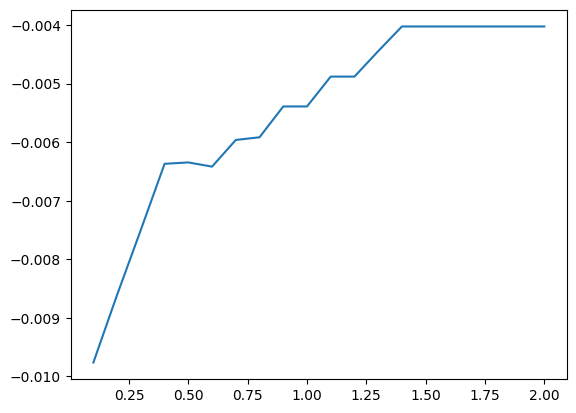

In [12]:
plt.plot(taus, scores)

In [307]:
best_tau = taus[np.argmin(scores)]
print(f'Best tau: {best_tau}')

Best tau: 0.8999999999999999


In [308]:
optimizer = ps.SR3(
        threshold=best_tau,
        thresholder="l1",
        max_iter=100000,
        normalize_columns=True,
        verbose=True,
    )
model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v'])
model_sindy.fit(u, x_dot=u_dot, t=t)
model_sindy.print()

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.0622e+01 ... 3.4056e+01 ... 3.2495e+02 ... 3.8963e+02
(u)' = -0.010 u_22
(v)' = -0.013 v_11
